Dane zostały wczytane do MongoDB.
Dodano nowego pasażera.

Pasażerowie poniżej 18 roku życia:
Palsson, Master. Gosta Leonard - 2.0
Nasser, Mrs. Nicholas (Adele Achem) - 14.0
Sandstrom, Miss. Marguerite Rut - 4.0
Vestrom, Miss. Hulda Amanda Adolfina - 14.0
Rice, Master. Eugene - 2.0
McGowan, Miss. Anna "Annie" - 15.0
Palsson, Miss. Torborg Danira - 8.0
Nicola-Yarred, Miss. Jamila - 14.0
Laroche, Miss. Simonne Marie Anne Andree - 3.0
Panula, Master. Juha Niilo - 7.0
West, Miss. Constance Mirium - 5.0
Goodwin, Master. William Frederick - 11.0
Skoog, Master. Harald - 4.0
Andersson, Miss. Erna Alexandra - 17.0
Goodwin, Miss. Lillian Amy - 16.0
Caldwell, Master. Alden Gates - 0.83
Ilett, Miss. Bertha - 17.0
Ford, Mr. William Neal - 16.0
Zabour, Miss. Hileni - 14.5
Attalah, Miss. Malake - 17.0
Andersson, Miss. Ellis Anna Maria - 2.0
Nicola-Yarred, Master. Elias - 12.0
Osen, Mr. Olaf Elon - 16.0
Ford, Miss. Robina Maggie "Ruby" - 9.0
Gilnagh, Miss. Katherine "Katie" - 16.0
Calic, Mr. Jovo - 17

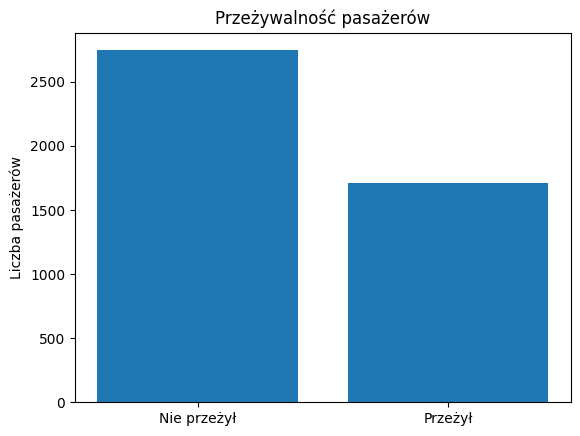

In [2]:
import pandas as pd
from pymongo import MongoClient

# 1. Połączenie z MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['titanic']
collection = db['passengers']

# 2. Wczytanie danych z pliku CSV
df = pd.read_csv('train.csv')

# 3. Konwersja DataFrame do listy słowników i wstawienie do MongoDB
data_dict = df.to_dict("records")
collection.insert_many(data_dict)

print("Dane zostały wczytane do MongoDB.")

# --- CREATE ---
new_passenger = {
    "PassengerId": 1000,
    "Name": "Testowy Pasazer",
    "Sex": "male",
    "Age": 30,
    "Survived": 0
}
collection.insert_one(new_passenger)
print("Dodano nowego pasażera.")

# --- READ ---
print("\nPasażerowie poniżej 18 roku życia:")
young_passengers = collection.find({"Age": {"$lt": 18}})
for p in young_passengers:
    print(p["Name"], "-", p.get("Age", "Brak danych"))

# --- UPDATE ---
collection.update_one({"Name": "Testowy Pasazer"}, {"$set": {"Survived": 1}})
print("Zaktualizowano status przeżycia testowego pasażera.")

# --- DELETE ---
collection.delete_one({"Name": "Testowy Pasazer"})
print("Usunięto testowego pasażera.")

import matplotlib.pyplot as plt

# Pobranie danych z MongoDB do DataFrame
data_from_db = pd.DataFrame(list(collection.find()))

# Prosty wykres: liczba ocalałych vs nieocalałych
survival_counts = data_from_db['Survived'].value_counts()
plt.bar(['Nie przeżył', 'Przeżył'], survival_counts)
plt.title('Przeżywalność pasażerów')
plt.ylabel('Liczba pasażerów')
plt.show()


Dane zostały wczytane do MongoDB.


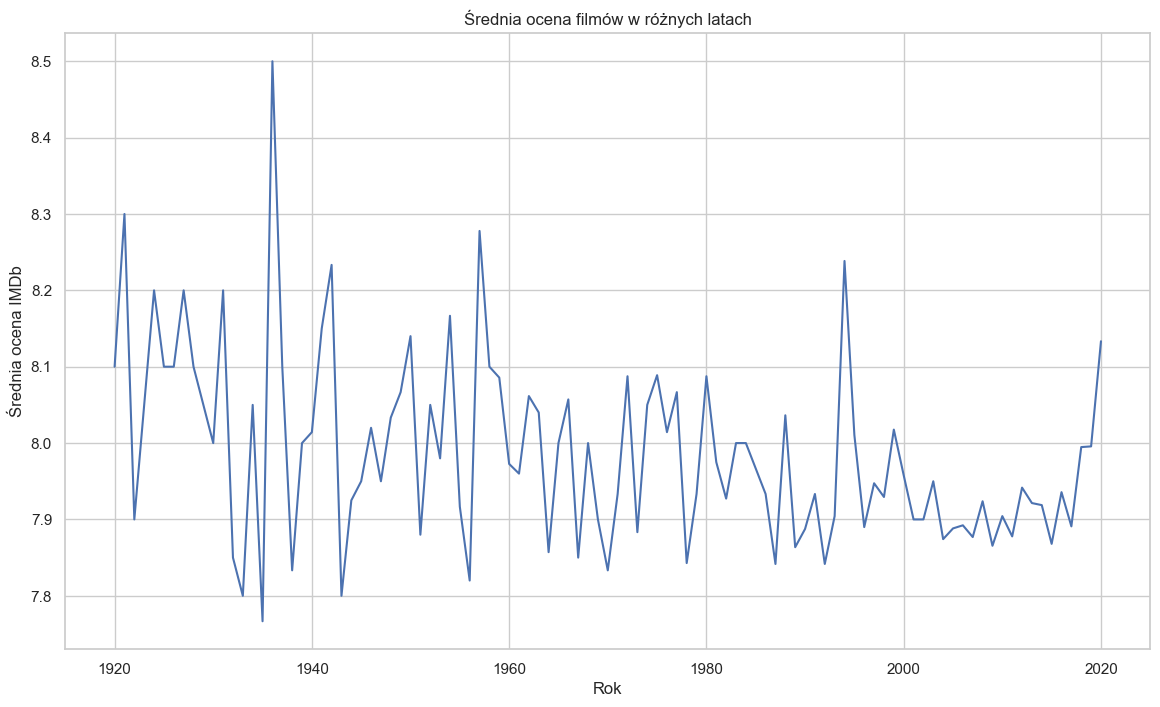

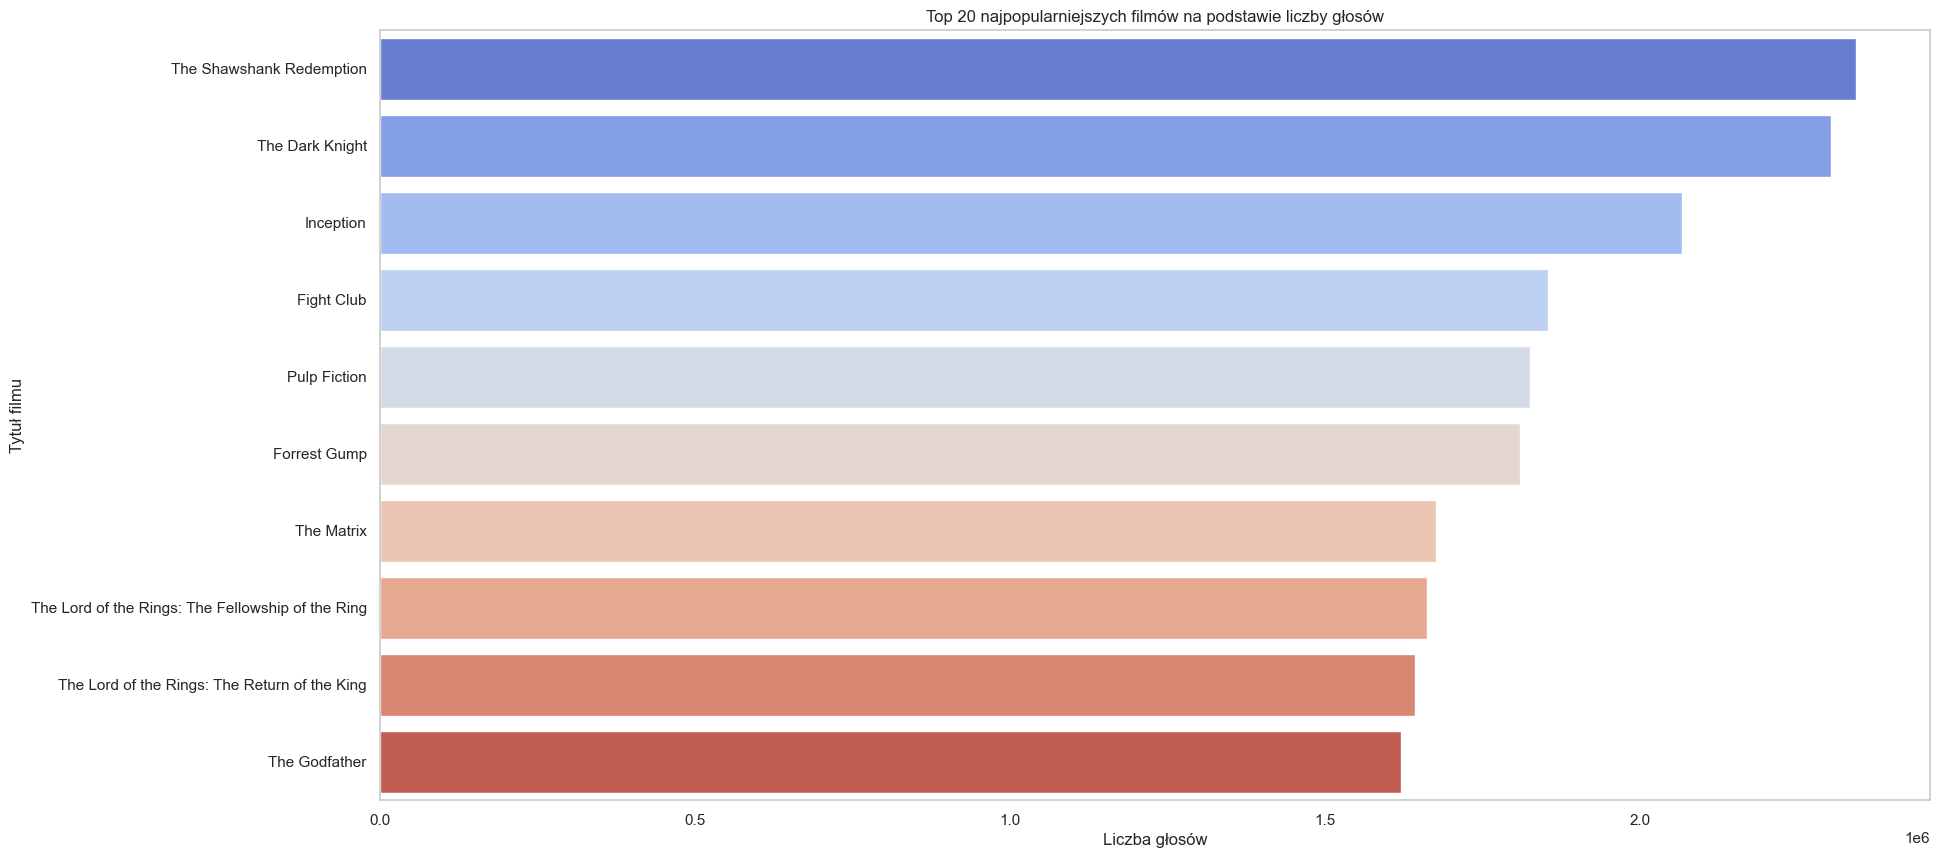

In [16]:
import pandas as pd
from pymongo import MongoClient
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Połączenie z MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['imdb']
collection = db['movies']

# 2. Wczytanie danych z pliku CSV
df = pd.read_csv('imdb_top_1000.csv')

# Czyszczenie danych (usunięcie przecinków w kolumnach numerycznych, konwersja typów)
df['Gross'] = df['Gross'].replace({',': ''}, regex=True).astype(float, errors='ignore')
df['Released_Year'] = pd.to_numeric(df['Released_Year'], errors='coerce')

# 3. Konwersja DataFrame do listy słowników i wstawienie do MongoDB
data_dict = df.to_dict("records")
collection.insert_many(data_dict)
print("Dane zostały wczytane do MongoDB.")

# 4. Zaawansowane operacje agregacyjne w MongoDB
pipeline = [
    {
        "$group": {
            "_id": "$Released_Year",
            "średnia_ocena": {"$avg": "$IMDB_Rating"},
            "najpopularniejsze_filmy": {"$push": {
                "tytuł": "$Series_Title",
                "ocena": "$IMDB_Rating",
                "liczba_głosów": "$No_of_Votes"
            }}
        }
    },
    {"$sort": {"_id": 1}}
]
result = list(collection.aggregate(pipeline))

# 5. Przetwarzanie wyników w pandas
aggregated_df = pd.DataFrame(result)

# Rozpakowanie szczegółowych danych o filmach (opcjonalne, zależnie od potrzeby)
movies_per_year = pd.DataFrame([
    {"Year": r["_id"], "Title": movie["tytuł"], "Rating": movie["ocena"], "Votes": movie["liczba_głosów"]}
    for r in result for movie in r["najpopularniejsze_filmy"]
])

# 6. Wizualizacja wyników w Seaborn
plt.figure(figsize=(14, 8))
sns.lineplot(data=aggregated_df, x="_id", y="średnia_ocena")
plt.title('Średnia ocena filmów w różnych latach')
plt.xlabel('Rok')
plt.ylabel('Średnia ocena IMDb')
plt.grid(True)
plt.show()

plt.figure(figsize=(20, 10))
sns.barplot(
    data=movies_per_year.sort_values("Votes", ascending=False)[:20],
    x="Votes",
    y="Title",
    hue="Title",  # Dodano przypisanie 'hue'
    dodge=False,  # Zapewniono brak przesunięcia przy użyciu hue
    palette="coolwarm",
    legend=False  # Wyłączenie legendy
)
plt.title('Top 20 najpopularniejszych filmów na podstawie liczby głosów')
plt.xlabel('Liczba głosów')
plt.ylabel('Tytuł filmu')
plt.grid(axis="x")
plt.show()

Serwer NOAA chwilowo niedostępny dla roku 2017. Pomijam ten rok.
Wstawiono 7305 rekordów do kolekcji NOAA.
Brak danych Climate Change.
Tworzę wizualizację danych NOAA...


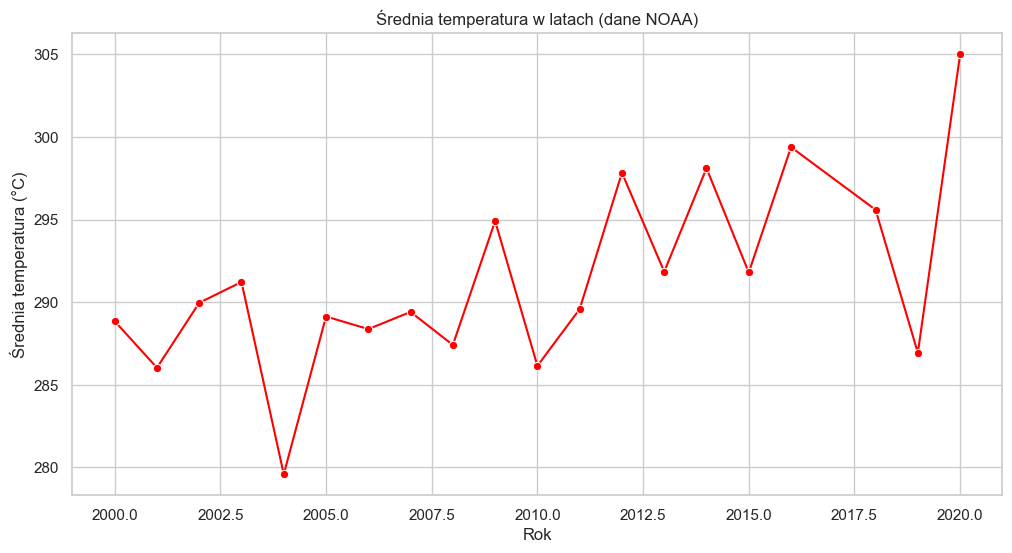

In [26]:
import requests
from pymongo import MongoClient
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Funkcja do pobierania danych NOAA
def fetch_noaa_data(start_year, end_year):
    noaa_url = "https://www.ncdc.noaa.gov/cdo-web/api/v2/data"
    headers = {
        'token': 'XrqMKCQIFrGpQjaXYnUunEqGRTqZtIqw'  # Token API
    }
    all_data = []

    for year in range(start_year, end_year + 1):
        params = {
            'datasetid': 'GHCND',
            'datatypeid': 'TMAX',
            'startdate': f'{year}-01-01',
            'enddate': f'{year}-12-31',
            'stationid': 'GHCND:USW00023160',
            'limit': 1000
        }
        response = requests.get(noaa_url, headers=headers, params=params)

        if response.status_code == 200:
            data_noaa = response.json()
            if 'results' in data_noaa:
                all_data.extend(data_noaa['results'])  # Dodajemy dane
            else:
                print(f"Brak wyników dla roku {year}.")
        elif response.status_code == 503:
            print(f"Serwer NOAA chwilowo niedostępny dla roku {year}. Pomijam ten rok.")
        else:
            print(f"Błąd pobierania danych NOAA dla roku {year}: {response.status_code}, {response.text}")

    if all_data:
        return pd.DataFrame(all_data)
    else:
        return pd.DataFrame()

# Pobieranie danych NOAA
noaa_df = fetch_noaa_data(2000, 2020)

# Climate Change: Brak obsługiwanych danych
climate_df = pd.DataFrame()

# Wczytanie danych do MongoDB
client = MongoClient("mongodb://localhost:27017/")
mydb = client["climate_database"]
noaa_col = mydb["noaa_data"]
climate_col = mydb["climate_change_data"]

if not noaa_df.empty:
    noaa_col.delete_many({})
    noaa_col.insert_many(noaa_df.to_dict(orient="records"))
    print(f"Wstawiono {len(noaa_df)} rekordów do kolekcji NOAA.")
else:
    print("Brak danych do wstawienia do NOAA.")

if not climate_df.empty:
    climate_col.delete_many({})
    climate_col.insert_many(climate_df.to_dict(orient="records"))
    print(f"Wstawiono {len(climate_df)} rekordów do kolekcji Climate Change.")
else:
    print("Brak danych Climate Change.")

# Wizualizacja danych NOAA, jeśli istnieją
if not noaa_df.empty:
    print("Tworzę wizualizację danych NOAA...")
    noaa_df['date'] = pd.to_datetime(noaa_df['date'])
    noaa_df['Year'] = noaa_df['date'].dt.year
    noaa_avg_temp = noaa_df.groupby('Year')['value'].mean().reset_index()

    plt.figure(figsize=(12, 6))
    sns.lineplot(data=noaa_avg_temp, x='Year', y='value', marker='o', color='red')
    plt.xlabel('Rok')
    plt.ylabel('Średnia temperatura (°C)')
    plt.title('Średnia temperatura w latach (dane NOAA)')
    plt.grid(True)
    plt.show()
else:
    print("Brak danych NOAA do wizualizacji.")